In [38]:
import pandas as pd
from dfply import *
import sys
from sshtunnel import SSHTunnelForwarder
import logging
import missingno as msno
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [3]:
# 데이터 저장위치
output_dir = '../outputs'

# SSH 연결 설정
ssh_config = {
    'ssh_ip': '210.91.223.248',
    'ssh_port': 35430,
    'ssh_username': "medicalai",
    'ssh_password': "medicalai731!",
    'remote_bind_address': ('localhost', 35432)  # 데이터베이스 호스트 및 포트
}

# 데이터베이스 연결 설정
db_config = {
    'database': 'mimiciv',
    'user': 'mai_admin',
    'password': 'admin1q2w!@',
    'host': 'localhost',  # SSH 터널을 사용하면, 이 값은 'localhost'가 됩니다
    'port': 35432  # 이 값은 SSH 터널 로컬 포트 바인딩에 의해 대체됩니다
}

# 호흡기 ITEM ID 설정 (웬만하면 건들지 마세요)
vent_ids_config = {
    'INTUBATION_ITEM_IDS': "224385",
    'EXTUBATION_ITEM_IDS': "225468, 225477, 227194"
}

# 테이블 쿼리 설정
tables_query = {
    # 'pg_tables': 'SELECT * FROM PG_TABLES;',
    # 'patients': 'SELECT * FROM mimiciv_hosp.patients;',
    # 'admissions': 'SELECT * FROM mimiciv_hosp.admissions;',
    # 'transfers': 'SELECT * FROM mimiciv_hosp.transfers;',
    # 'icustays': 'SELECT * FROM mimiciv_icu.icustays;',
    'd_items': 'SELECT * FROM mimiciv_icu.d_items;',
    'intubation': f"SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN ({vent_ids_config['INTUBATION_ITEM_IDS']});",
    'extubation': f"SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN ({vent_ids_config['EXTUBATION_ITEM_IDS']});"
}

# 추가 설정 (웬만하면 건들지 마세요)
additional_config = {
    'TIME_DIFF_DUP': 30   # time_diff_dup: 몇 분 이내에 삽관/발관 이벤트를 중복으로 정의할 것인가? (디폴트: 30분)
}

db.print_config_info(db_config, tables_query)

--------- Database Configuration ---------
Database Name: mimiciv
User: mai_admin
Password: ***********
Host: localhost
Port: 35432

--------- SQL Queries for Required Tables ---------
d_items: SELECT * FROM mimiciv_icu.d_items;
intubation: SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN (224385);
extubation: SELECT * FROM mimiciv_icu.procedureevents WHERE itemid IN (225468, 225477, 227194);



In [4]:
# db 접속, 테이블 추출, 'dataframes' 라는 딕셔너리에 테이블 저장
try:
    conn, tunnel = db.connect_to_database_via_ssh(db_config, ssh_config)
    if conn is not None:
        # 데이터베이스 작업 수행
        dataframes = db.retrieve_data(conn, tables_query)
    else:
        logging.error("Failed to connect to the database.")
except Exception as e:
    logging.error(f"An error occurred: {e}")
finally:
    if conn is not None:
        db.disconnect_database(conn)

        
    # if tunnel is not None:
    #     tunnel.close()
    #     logging.info("SSH TUNNEL CLOSED.")

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_8.2p1)
INFO:paramiko.transport:Authentication (password) successful!
INFO:root:SSH TUNNEL ESTABLISHED...
INFO:root:mimiciv DATABASE CONNECTED VIA SSH.
INFO:root:Retrieved d_items: (4014, 9)
INFO:root:Retrieved intubation: (8488, 22)
INFO:root:Retrieved extubation: (23122, 22)
INFO:root:DATABASE CONNCETION CLOSED.


In [6]:
d_items = dataframes['d_items']
d_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,None,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,None,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4009,230077,Documented on DC Summary (PICC),Documented on DC Summary (PICC),chartevents,PICC Line Insertion,None,Text,NaN,NaN
4010,230078,Documented on DC Summary (Thora),Documented on DC Summary (Thora),chartevents,Thoracentesis,None,Text,NaN,NaN
4011,230083,Replacement Fluid (Pre-Filter),Replacement Fluid (Pre-Filter),chartevents,Dialysis,None,Text,NaN,NaN
4012,230084,Replacement Fluid (Post-Filter),Replacement Fluid (Post-Filter),chartevents,Dialysis,None,Text,NaN,NaN


In [8]:
d_items[d_items.itemid.eq(224385)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
665,224385,Intubation,Intubation,procedureevents,1-Intubation/Extubation,None,Processes,NaN,NaN


In [11]:
d_items[d_items.itemid.isin([225468, 225477, 227194])]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1324,225468,Unplanned Extubation (patient-initiated),Unplanned Extubation (patient-initiated),procedureevents,1-Intubation/Extubation,None,Processes,NaN,NaN
1331,225477,Unplanned Extubation (non-patient initiated),Unplanned Extubation (non-patient initiated),procedureevents,1-Intubation/Extubation,None,Processes,NaN,NaN
2141,227194,Extubation,Extubation,procedureevents,1-Intubation/Extubation,None,Processes,NaN,NaN


In [9]:
intubation = dataframes['intubation']
intubation

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,value,valueuom,...,orderid,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,10001884,26184834,37510196,42150,2131-01-11 04:30:00,2131-01-11 04:31:00,2131-01-11 05:40:00,224385,1.0,None,...,2338046,2338046,Intubation/Extubation,Task,65.0,0,0,FinishedRunning,1.0,0.0
1,10003400,23559586,38383343,36212,2137-08-17 21:21:00,2137-08-17 21:22:00,2137-08-17 21:21:00,224385,1.0,None,...,9156137,9156137,Intubation/Extubation,Task,90.5,0,0,FinishedRunning,1.0,0.0
2,10004401,27939719,31202136,58760,2144-04-11 05:03:00,2144-04-11 05:04:00,2144-04-11 05:03:00,224385,1.0,None,...,991564,991564,Intubation/Extubation,Task,120.0,0,0,FinishedRunning,1.0,0.0
3,10004401,29988601,32773003,38908,2144-01-27 19:00:00,2144-01-27 19:01:00,2144-01-27 19:12:00,224385,1.0,None,...,4299790,4299790,Intubation/Extubation,Task,76.0,0,0,FinishedRunning,1.0,0.0
4,10004401,29988601,32773003,42665,2144-01-30 13:00:00,2144-01-30 13:01:00,2144-01-30 13:05:00,224385,1.0,None,...,6177150,6177150,Intubation/Extubation,Task,76.0,0,0,FinishedRunning,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8483,19995595,21784060,34670930,48419,2126-10-31 00:45:00,2126-10-31 00:46:00,2126-10-31 01:19:00,224385,1.0,None,...,8453993,8453993,Intubation/Extubation,Task,94.7,0,0,FinishedRunning,1.0,0.0
8484,19997293,20208898,38350444,58760,2123-10-20 04:05:00,2123-10-20 04:06:00,2123-10-20 04:39:00,224385,1.0,None,...,4889483,4889483,Intubation/Extubation,Task,134.5,0,0,FinishedRunning,1.0,0.0
8485,19997367,20617667,35616526,10976,2126-04-26 20:14:00,2126-04-26 20:15:00,2126-04-26 21:14:00,224385,1.0,None,...,5095062,5095062,Intubation/Extubation,Task,59.0,0,0,FinishedRunning,1.0,0.0
8486,19997367,20617667,35616526,27479,2126-05-05 18:20:00,2126-05-05 18:21:00,2126-05-05 18:20:00,224385,1.0,None,...,8462542,8462542,Intubation/Extubation,Task,59.0,0,0,FinishedRunning,1.0,0.0


In [12]:
extubation = dataframes['extubation']
extubation

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,value,valueuom,...,orderid,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,10001884,26184834,37510196,35966,2131-01-12 17:40:00,2131-01-12 17:41:00,2131-01-12 17:50:00,227194,1.0,None,...,6470885,6470885,Intubation/Extubation,Task,65.0,0,0,FinishedRunning,1.0,0.0
1,10002013,23581541,39060235,65197,2160-05-18 18:00:00,2160-05-18 18:01:00,2160-05-18 17:59:00,227194,1.0,None,...,3546453,3546453,Intubation/Extubation,Task,96.0,0,0,FinishedRunning,1.0,0.0
2,10002428,23473524,35479615,42665,2156-05-20 10:45:00,2156-05-20 10:46:00,2156-05-20 10:51:00,227194,1.0,None,...,9794232,9794232,Intubation/Extubation,Task,48.4,0,0,FinishedRunning,1.0,0.0
3,10002428,28662225,38875437,3009,2156-04-22 17:10:00,2156-04-22 17:11:00,2156-04-22 17:10:00,227194,1.0,None,...,9954431,9954431,Intubation/Extubation,Task,43.0,0,0,FinishedRunning,1.0,0.0
4,10002760,28094813,31831386,50512,2141-04-21 08:00:00,2141-04-21 08:01:00,2141-04-21 08:04:00,227194,1.0,None,...,2857656,2857656,Intubation/Extubation,Task,91.0,0,0,FinishedRunning,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23117,19954261,20156947,31459880,34131,2114-04-18 12:07:00,2114-04-18 12:08:00,2114-04-18 12:07:00,227194,1.0,None,...,6328663,6328663,Intubation/Extubation,Task,75.9,0,0,FinishedRunning,1.0,0.0
23118,19955320,20298446,36067553,86518,2188-05-27 21:08:00,2188-05-27 21:09:00,2188-05-27 23:32:00,227194,1.0,None,...,9002314,9002314,Intubation/Extubation,Task,104.0,0,0,FinishedRunning,1.0,0.0
23119,19955371,26497119,36204037,62802,2144-08-02 13:15:00,2144-08-02 13:16:00,2144-08-02 13:17:00,227194,1.0,None,...,2197171,2197171,Intubation/Extubation,Task,97.1,0,0,FinishedRunning,1.0,0.0
23120,19956723,23886623,33940420,35966,2194-10-30 08:20:00,2194-10-30 08:21:00,2194-10-30 08:40:00,227194,1.0,None,...,7708782,7708782,Intubation/Extubation,Task,92.0,0,0,FinishedRunning,1.0,0.0


2024-03-06 12:27:12,577| ERROR   | Socket exception: Connection reset by peer (54)
ERROR:paramiko.transport:Socket exception: Connection reset by peer (54)


In [16]:
df = pd.read_csv('../outputs/subjectlist1.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', 'reintubation_eventtime', 'dischtime', 'deathtime'])
df

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,...,2230.0,NaT,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,...,5419.0,NaT,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,31202136.0,2144-04-13 15:00:00,...,3477.0,NaT,NaN,False,True,NaN,151.0,NaN,121,nonfailure
3,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,...,3930.0,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,...,10005.0,NaT,NaN,False,True,NaN,0.0,NaN,2221,nonfailure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,...,8416.0,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure
8999,19997367,20617667,35616526,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,...,4269.0,NaT,NaN,False,True,NaN,15646.0,NaN,221,nonfailure
9000,19999068,21606769,30143796,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,...,4201.0,NaT,NaN,False,True,NaN,7525.0,NaN,11,nonfailure
9001,19999442,26785317,32336619,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,...,1155.0,NaT,NaN,True,True,NaN,20290.0,NaN,11,nonfailure


다중 시퀀스의 마지막 행 중 발관시간이 퇴원시간이나 사망시각보다 뒤에 오는 경우가 있던가?

In [17]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'int_stayid', 'admittime',
       'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'transfer',
       'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class'],
      dtype='object')

In [34]:
final_df = df[(df.final_event == True)]
final_df[(final_df.ext_to_disch < 0) & (final_df['class'] == 'nonfailure')][['extubationtime', 'dischtime']]

,extubationtime,dischtime
5989,2126-01-14 15:00:00,2126-01-14 14:00:00
7629,2130-02-16 11:41:00,2130-02-16 11:24:00
7631,2144-11-09 14:30:00,2144-11-09 08:00:00


In [35]:
df.intext_duration.describe()

count      7440.000000
mean       5905.394624
std        9322.264408
min       -1129.000000
25%        1040.000000
50%        2875.500000
75%        7265.750000
max      188976.000000
Name: intext_duration, dtype: float64

In [36]:
df.groupby(['hadm_id'])['intext_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
hadm_id,,,,,,,,
20001361,1.0,1154.0,NaN,1154.0,1154.0,1154.0,1154.0,1154.0
20004357,1.0,2548.0,NaN,2548.0,2548.0,2548.0,2548.0,2548.0
20005119,1.0,35030.0,NaN,35030.0,35030.0,35030.0,35030.0,35030.0
20005241,1.0,388.0,NaN,388.0,388.0,388.0,388.0,388.0
20014219,1.0,15123.0,NaN,15123.0,15123.0,15123.0,15123.0,15123.0
...,...,...,...,...,...,...,...,...
29991539,1.0,18190.0,NaN,18190.0,18190.0,18190.0,18190.0,18190.0
29992577,1.0,1810.0,NaN,1810.0,1810.0,1810.0,1810.0,1810.0
29995505,1.0,24513.0,NaN,24513.0,24513.0,24513.0,24513.0,24513.0


before after null 비교

In [51]:
df_original = pd.read_csv('../outputs/paired_df.csv', index_col=0, parse_dates=['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime'])
df_original

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,1
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,1
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,1
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,2
9004,19997367,20617667,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,3
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,1
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1


In [57]:
df_original[df_original.intubationtime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
14,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,227194.0,102.5,Planned Extubation,2150-04-25 13:50:00,NaT,NaN,3
15,10020740,23831430,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,227194.0,103.0,Planned Extubation,2150-04-25 13:50:00,NaT,NaN,4
19,10024982,25154057,NaN,2203-09-19 12:29:00,NaT,NaN,NaN,37919901.0,2203-09-28 17:00:00,227194.0,79.1,Planned Extubation,2203-10-11 19:10:00,2203-10-11 19:10:00,NaN,2
22,10027602,28166872,NaN,2201-10-30 12:05:00,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,227194.0,64.0,Planned Extubation,2201-11-20 14:45:00,NaT,NaN,2
52,10085667,27382550,NaN,2192-12-11 19:38:00,NaT,NaN,NaN,36886741.0,2192-12-14 14:36:00,227194.0,95.3,Planned Extubation,2192-12-19 17:30:00,NaT,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975,19965802,21104872,NaN,2121-12-27 20:28:00,NaT,NaN,NaN,34618456.0,2122-01-04 15:50:00,227194.0,101.3,Planned Extubation,2122-01-20 16:40:00,NaT,NaN,2
8987,19975796,25848942,NaN,2148-12-02 22:08:00,NaT,NaN,NaN,31651964.0,2148-12-03 10:33:00,227194.0,72.0,Planned Extubation,2148-12-14 16:00:00,NaT,NaN,2
8997,19989918,20256395,NaN,2175-09-18 17:45:00,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,227194.0,124.4,Planned Extubation,2175-09-28 17:45:00,NaT,NaN,2
9001,19995595,21784060,NaN,2126-10-17 21:43:00,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,227194.0,94.7,Planned Extubation,2126-11-12 17:35:00,NaT,NaN,2


In [58]:
df_original[df_original.extubationtime.isna()]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,seq_num
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,1
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,2
6,10007818,22987108,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,NaN,NaT,NaN,NaN,NaN,2146-07-12 00:00:00,2146-07-12 20:50:00,NaN,1
7,10010058,26359957,33060379.0,2147-11-18 02:34:00,2147-11-18 02:35:00,224385.0,60.0,NaN,NaT,NaN,NaN,NaN,2147-11-19 04:00:00,2147-11-19 04:00:00,NaN,1
9,10017531,22580355,35526828.0,2159-09-22 19:30:00,2159-09-23 16:01:00,224385.0,119.0,NaN,NaT,NaN,NaN,NaN,2159-10-24 13:40:00,NaT,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,19971771,26230047,38668070.0,2117-04-26 00:21:00,2117-04-26 00:22:00,224385.0,90.0,NaN,NaT,NaN,NaN,NaN,2117-05-25 11:15:00,NaT,NaN,1
8989,19979469,29434840,37363141.0,2202-02-22 18:26:00,2202-02-22 21:40:00,224385.0,86.0,NaN,NaT,NaN,NaN,NaN,2202-02-28 18:20:00,NaT,NaN,1
8991,19983257,21588174,31169972.0,2166-06-13 14:21:00,2166-06-19 09:20:00,224385.0,118.6,NaN,NaT,NaN,NaN,NaN,2166-06-19 21:15:00,2166-06-19 21:15:00,NaN,2
8998,19990427,29695607,34058245.0,2182-01-04 00:00:00,2182-01-14 04:21:00,224385.0,100.0,NaN,NaT,NaN,NaN,NaN,2182-01-24 00:00:00,2182-01-24 23:15:00,NaN,1


In [59]:
df[df.intubationtime.isna()]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
12,10020740,23831430,35026312,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35026312.0,2150-03-12 18:15:00,...,NaN,NaT,NaN,False,False,NaN,63095.0,NaN,9999,NaN
13,10020740,23831430,35044342,NaN,2150-03-11 15:34:00,NaT,NaN,NaN,35044342.0,2150-03-19 11:05:00,...,NaN,2150-03-27 07:44:00,11319.0,False,False,NaN,53445.0,NaN,212,nonfailure
18,10024982,25154057,37919901,NaN,2203-09-19 12:29:00,NaT,NaN,NaN,37919901.0,2203-09-28 17:00:00,...,NaN,2203-10-02 11:00:00,5400.0,False,False,18850.0,18850.0,0.0,212,nonfailure
21,10027602,28166872,32391858,NaN,2201-10-30 12:05:00,NaT,NaN,NaN,32391858.0,2201-11-07 13:53:00,...,NaN,2201-11-07 15:00:00,67.0,False,False,NaN,18772.0,NaN,211,failure
51,10085667,27382550,36886741,NaN,2192-12-11 19:38:00,NaT,NaN,NaN,36886741.0,2192-12-14 14:36:00,...,NaN,2192-12-15 22:30:00,1914.0,False,False,NaN,7374.0,NaN,211,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,19965802,21104872,34618456,NaN,2121-12-27 20:28:00,NaT,NaN,NaN,34618456.0,2122-01-04 15:50:00,...,NaN,2122-01-13 01:00:00,12070.0,False,False,NaN,23090.0,NaN,212,nonfailure
8981,19975796,25848942,31651964,NaN,2148-12-02 22:08:00,NaT,NaN,NaN,31651964.0,2148-12-03 10:33:00,...,NaN,2148-12-04 20:15:00,2022.0,False,False,NaN,16167.0,NaN,211,failure
8992,19989918,20256395,35582926,NaN,2175-09-18 17:45:00,NaT,NaN,NaN,35582926.0,2175-09-26 16:00:00,...,NaN,NaT,NaN,False,True,NaN,2985.0,NaN,221,nonfailure
8995,19995595,21784060,34670930,NaN,2126-10-17 21:43:00,NaT,NaN,NaN,34670930.0,2126-10-30 14:26:00,...,NaN,2126-10-31 00:45:00,619.0,False,False,NaN,18909.0,NaN,211,failure


In [60]:
df[df.extubationtime.isna()]

,subject_id,hadm_id,stay_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,...,intext_duration,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
47,10079700,24239751,38841663,38841663.0,2115-09-14 22:01:00,2115-09-27 17:23:00,224385.0,64.0,NaN,NaT,...,NaN,2115-10-11 14:05:00,NaN,False,False,NaN,NaN,NaN,9999,NaN
55,10090454,29525590,38669202,38669202.0,2169-02-05 17:14:00,2169-02-06 19:00:00,224385.0,54.0,NaN,NaT,...,NaN,2169-02-10 16:22:00,NaN,False,False,NaN,NaN,0.0,9999,NaN
61,10098215,22394571,32817342,32817342.0,2118-05-03 23:07:00,2118-05-09 19:02:00,224385.0,60.0,NaN,NaT,...,NaN,2118-06-03 20:00:00,NaN,False,False,NaN,NaN,NaN,9999,NaN
62,10098215,22394571,36018186,36018186.0,2118-05-03 23:07:00,2118-06-03 20:00:00,224385.0,55.4,NaN,NaT,...,NaN,2118-06-03 20:50:00,NaN,False,False,NaN,NaN,NaN,998,failure
100,10136619,23362878,31093046,31093046.0,2141-01-16 16:18:00,2141-01-21 07:55:00,224385.0,55.5,NaN,NaT,...,NaN,2141-01-23 04:30:00,NaN,False,False,NaN,NaN,0.0,998,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914,19893454,28167991,31167245,31167245.0,2163-04-14 00:00:00,2163-04-25 08:45:00,224385.0,108.0,NaN,NaT,...,NaN,NaT,NaN,False,True,NaN,NaN,NaN,9999,NaN
8931,19913577,20355379,37544707,37544707.0,2114-05-01 20:02:00,2114-05-27 19:51:00,224385.0,85.0,NaN,NaT,...,NaN,NaT,NaN,False,True,NaN,NaN,1224.0,9999,NaN
8954,19949739,25237531,32028235,32028235.0,2145-05-31 14:41:00,2145-05-31 18:59:00,224385.0,57.5,NaN,NaT,...,NaN,2145-06-03 04:00:00,NaN,False,False,NaN,NaN,0.0,9999,NaN
8962,19960105,27292691,31512322,31512322.0,2147-08-06 18:06:00,2147-08-09 01:10:00,224385.0,56.8,NaN,NaT,...,NaN,2147-08-15 12:40:00,NaN,False,False,NaN,NaN,NaN,9999,NaN


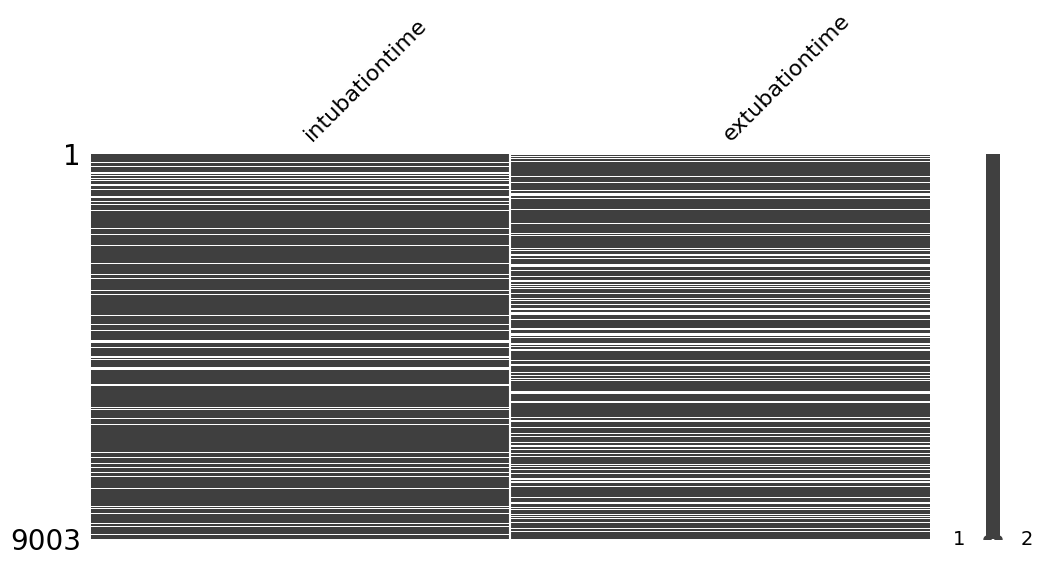

In [52]:
# before
msno.matrix(df_original[['intubationtime', 'extubationtime']], figsize=(12,5));

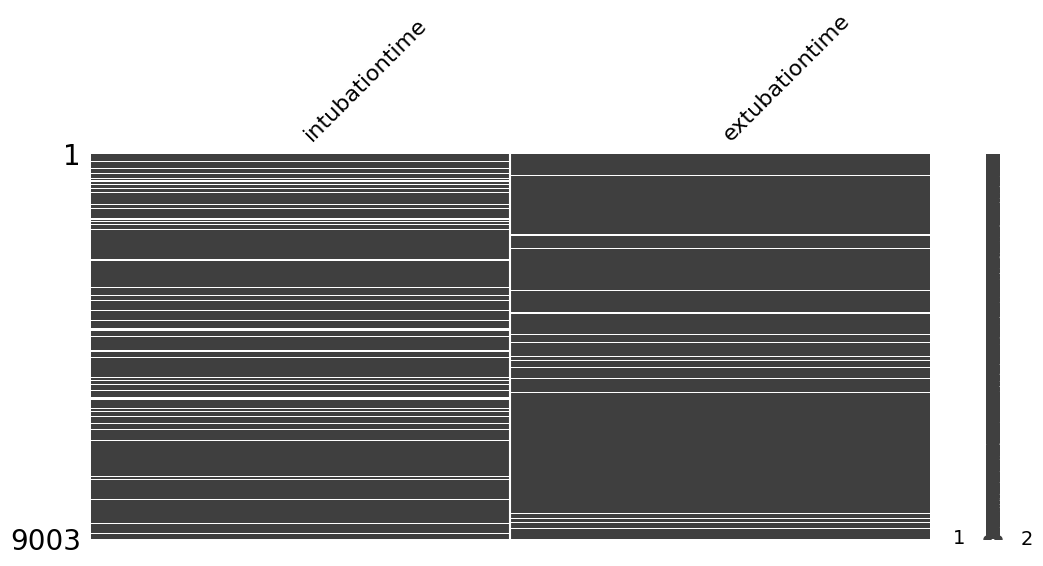

In [53]:
# after
msno.matrix(df[['intubationtime', 'extubationtime']], figsize=(12,5));

In [61]:
df_original.intubationtime.isna().sum()

1143

In [62]:
df.intubationtime.isna().sum()

1143